In [ ]:
%pip install pyspark

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext
sc = SparkContext('local')
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('salary.csv')
df.take(1)

[Row(age=39, workclass=' State-gov', fnlwgt=77516, education=' Bachelors', education-num=13, marital-status=' Never-married', occupation=' Adm-clerical', relationship=' Not-in-family', race=' White', sex=' Male', capital-gain=2174, capital-loss=0, hours-per-week=40, native-country=' United-States', salary=' <=50K')]

In [ ]:
df.cache()
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- salary: string (nullable = true)



In [ ]:
df.dtypes

[('age', 'int'),
 ('workclass', 'string'),
 ('fnlwgt', 'int'),
 ('education', 'string'),
 ('education-num', 'int'),
 ('marital-status', 'string'),
 ('occupation', 'string'),
 ('relationship', 'string'),
 ('race', 'string'),
 ('sex', 'string'),
 ('capital-gain', 'int'),
 ('capital-loss', 'int'),
 ('hours-per-week', 'int'),
 ('native-country', 'string'),
 ('salary', 'string')]

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer0 = StringIndexer(inputCol="workclass", outputCol="workclassEncoded") 
indexed0 = indexer0.fit(df).transform(df) 
indexer1 = StringIndexer(inputCol="education", outputCol="educationEncoded") 
indexed1 = indexer1.fit(indexed0).transform(indexed0) 
indexer2 = StringIndexer(inputCol="occupation", outputCol="occupationEncoded") 
indexed2 = indexer2.fit(indexed1).transform(indexed1) 
indexer3 = StringIndexer(inputCol="sex", outputCol="sexEncoded") 
indexed3 = indexer3.fit(indexed2).transform(indexed2) 
indexer4 = StringIndexer(inputCol="native-country", outputCol="countryEncoded") 
indexed4 = indexer4.fit(indexed3).transform(indexed3) 
indexer5 = StringIndexer(inputCol="salary", outputCol="salaryEncoded") 
indexed5 = indexer5.fit(indexed4).transform(indexed4) 

In [ ]:
indexed5.show()

+---+-----------------+------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+----------------+----------------+-----------------+----------+--------------+-------------+
|age|        workclass|fnlwgt|    education|education-num|      marital-status|        occupation|  relationship|               race|    sex|capital-gain|capital-loss|hours-per-week|native-country|salary|workclassEncoded|educationEncoded|occupationEncoded|sexEncoded|countryEncoded|salaryEncoded|
+---+-----------------+------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+----------------+----------------+-----------------+----------+--------------+-------------+
| 39|        State-gov| 77516|    Bachelors|           13|       Never-married|      Adm-clerical| Not-in-fam

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['age', 'workclassEncoded', 'educationEncoded', 'occupationEncoded', 'sexEncoded', 'countryEncoded', 'education-num', 'capital-gain', 'hours-per-week', 'capital-loss'], outputCol = 'features')
tdf = vectorAssembler.transform(indexed5)
print(tdf)
tdf = tdf.select(['features', 'salaryEncoded'])
tdf.show(3)

DataFrame[age: int, workclass: string, fnlwgt: int, education: string, education-num: int, marital-status: string, occupation: string, relationship: string, race: string, sex: string, capital-gain: int, capital-loss: int, hours-per-week: int, native-country: string, salary: string, workclassEncoded: double, educationEncoded: double, occupationEncoded: double, sexEncoded: double, countryEncoded: double, salaryEncoded: double, features: vector]
+--------------------+-------------+
|            features|salaryEncoded|
+--------------------+-------------+
|[39.0,4.0,2.0,3.0...|          0.0|
|[50.0,1.0,2.0,2.0...|          0.0|
|(10,[0,3,6,8],[38...|          0.0|
+--------------------+-------------+
only showing top 3 rows



In [ ]:
train, test = tdf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 22828
Test Dataset Count: 9733


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'salaryEncoded', maxIter=10, regParam=0.1)
lr = LogisticRegression(featuresCol = 'features', labelCol = 'salaryEncoded', maxIter=10)
lsvcModel = lsvc.fit(train)
lrModel = lr.fit(train)

In [ ]:
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

Coefficients: [0.009679140612290072,0.01342892012614891,0.02288921743340083,-0.02078106627747353,-0.2950315108516846,-0.00409190094569091,0.08860705973375242,6.137904532294593e-05,0.008667393334614108,0.0003678549301454241]
Intercept: -2.5735276509983613


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


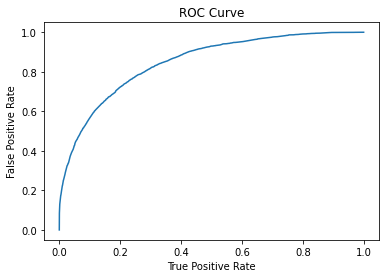

Training set areaUnderROC: 0.8475822185984571


In [ ]:
import matplotlib.pyplot as plt
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))